In [562]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import os
import matplotlib.pyplot as plt
from scipy.stats import norm

In [563]:
portfolio_prices = pd.read_excel("../../results/portfolio_returns_last3y.xlsx", index_col='Date', parse_dates=True)
portfolio = pd.read_excel("../../results/selected_assets_summary.xlsx", index_col='Ticker')

In [564]:
tickers = portfolio.index.tolist()
print(tickers)

['JGSA', 'SGLN', 'WMVG LN', 'MVEU LN Equity', 'TECW LN', 'ARTGEIG LN']


In [565]:
original_data = pd.read_excel("etf_combined.xlsx", index_col='Date', parse_dates=True)
log_returns = np.log(tickers_returns / tickers_returns.shift(1)).dropna()
tickers_returns = original_data[tickers]

In [566]:
# Use your expected returns (annualized) and convert to daily if needed
expected_returns = {
    'JGSA': 0.036863198,      # 3.28% expected return for cash (we chose cash for this etf)
        'SGLN': 0.0454,      # 4.54% expected return for gold, 2025 aritmetic return from JP Morgan
        'WMVG LN': 0.063439228,   # 6.6% Global ex-UK large cap equities
        'MVEU LN Equity': 0.069757684,  # 6.82% expected return for Europe large cap equities
        'TECW LN': 0.063439228,   # 6.58% expected return for tech
        'ARTGEIG LN': 0.071387404  # 8.15% expected return for EM
}
exp_series = pd.Series(expected_returns)
avg = (exp_series / 252).reindex(tickers).values

In [567]:
def expected_return(weights, _):
    expected_returns = {
        'JGSA': 0.036863198,      # 3.28% expected return for cash (we chose cash for this etf)
        'SGLN': 0.0454,      # 4.54% expected return for gold, 2025 aritmetic return from JP Morgan
        'WMVG LN': 0.063439228,   # 6.6% Global ex-UK large cap equities
        'MVEU LN Equity': 0.069757684,  # 6.82% expected return for Europe large cap equities
        'TECW LN': 0.063439228,   # 6.58% expected return for tech
        'ARTGEIG LN': 0.071387404  # 8.15% expected return for EM
    }
    exp_series = pd.Series(expected_returns)
    return (pd.Series(weights) * exp_series).sum()


In [568]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return float(np.sqrt(variance))

In [569]:
cov_matrix = log_returns.cov()
from matplotlib.colors import ListedColormap, BoundaryNorm

# Step 1: Define bins and custom colormap (from green to red)
#bins = [-1.0, 0.0, 0.3, 0.7, 0.9, 1.0]
#colors = ['#2DC94B', '#01A0DE', '#F1E87B', '#FFB549', '#CB333B']
#cmap = ListedColormap(colors)
#norm = BoundaryNorm(bins, len(colors))

# Create masked heatmap
#plt.figure(figsize=(10, 8))
#sns.heatmap(cov_matrix, annot=True, fmt=".4f", cmap="coolwarm", 
#            square=True, cbar=True, linewidths=0.5,
 #           xticklabels=True, yticklabels=True, 
  #          mask=np.triu(np.ones_like(cov_matrix, dtype=bool), k=1))
#plt.xticks(rotation=45)
#plt.title("Optimal Portfolio Covariance Matrix", fontsize=14)
#plt.tight_layout()
#plt.savefig(os.path.join('..', '..', 'results', 'optimal_covariance_heatmap.png'), dpi=300)
#print(cov_matrix)

In [582]:
portfolio_value = 20_000_000 # 20 million GBP
weights = portfolio["Weight"].values
portfolio_expected_return = expected_return(weights, avg)
portfolio_standard_deviation = standard_deviation(weights, cov_matrix)

# Run 10,000 simulations of the portfolio value at risk

simulations = 10000
scenario_return = []

In [583]:
def random_z_score():
    return np.random.normal(0,1)

In [584]:
# Create scenario to calculate a scenario GainLoss
days = 20 # We are saying "if in the next 5 days (lets say 95% confidence interval) what is the 5th percentile worst case scenario over 5 day period of money I can lose in this portfolio "

def scenario_gain_loss(portfolio_value, standard_deviation, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * standard_deviation * z_score * np.sqrt(days)

In [585]:
# Run 10,000 simulations of the portfolio value at risk

simulations = 10000
scenario_return = []

for i in range(simulations):
    z_score = random_z_score()
    scenario_return.append(scenario_gain_loss(portfolio_value, portfolio_standard_deviation, z_score, days))

In [586]:
confidence_interval = 0.95
var = -np.percentile(scenario_return, (1 - confidence_interval) * 100)
print(f"Value at Risk: {var:.2f}")

Value at Risk: 698606.06


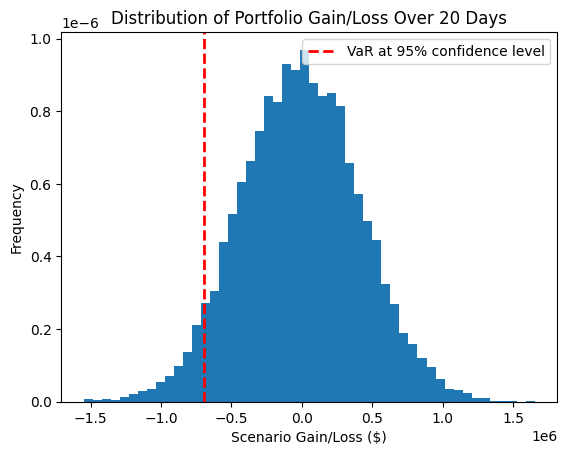

In [587]:
plt.hist(scenario_return, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-var, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.savefig(os.path.join('..', '..', 'results', 'portfolio_gain_loss_distribution.png'), dpi=300)
plt.show()

20-day 95% VaR = £480,247
20-day 99% VaR = £755,646


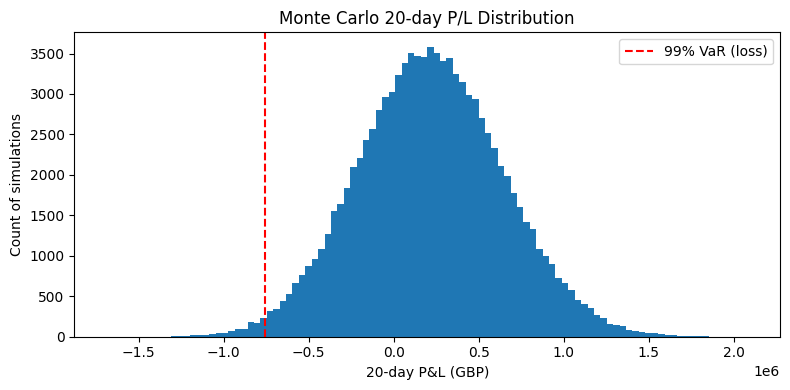

In [588]:


# --- CONFIGURATION -----------------------------------
n_sims        = 100_000    # number of Monte Carlo paths
horizon_days  = 20         # length of each path (e.g. 20 trading days)

w = portfolio["Weight"]

mean_daily = log_returns.mean()           
cov_daily  = log_returns.cov()            

# 2) simulate paths of *log returns* over T days
drift_vec = mean_daily.values * horizon_days
cov_mat   = cov_daily.values * horizon_days

# draw N samples of a T-day return vector
simulated = np.random.multivariate_normal(
    mean = drift_vec,
    cov  = cov_mat,
    size = n_sims
)   # shape = (n_sims, n_assets)

# 3) compute each path’s portfolio log-return, then P/L
#  log-return additivity over horizon, so port_log_ret = sum(w_i * sim_ret_i)
port_log_returns = simulated @ w.values            # shape = (n_sims,)
port_rets        = np.exp(port_log_returns) - 1    # convert *simulated* log‐returns to simple returns
pnl              = port_rets * portfolio_value     # P/L in GBP

# 4) VaR at 95% or 99% (left tail)
VaR_95 = np.percentile(pnl, 5)    # loss level exceeded 5% of the time
VaR_99 = np.percentile(pnl, 1)    # loss level exceeded 1% of the time

print(f"20-day 95% VaR = £{(-VaR_95):,.0f}")
print(f"20-day 99% VaR = £{(-VaR_99):,.0f}")

# 5) plot histogram
plt.figure(figsize=(8,4))
plt.hist(pnl, bins=100, density=False)
plt.axvline(VaR_99, color="red", linestyle="--", label="99% VaR (loss)")
plt.xlabel("20-day P&L (GBP)")
plt.ylabel("Count of simulations")
plt.legend()
plt.title("Monte Carlo 20-day P/L Distribution")
plt.tight_layout()
plt.show()

In [596]:
# 1) Inputs
horizons = [3, 4, 5]    # years out you care about
S0       = 20_000_000       # starting capital
w        = portfolio["Weight"].reindex(log_returns.columns).fillna(0.0)

# Blackstone (annual arithmetic) expected returns
exp_ret = pd.Series({
    'JGSA': 0.036863198,      # 3.28% expected return for cash (we chose cash for this etf)
    'SGLN': 0.0454,      # 4.54% expected return for gold, 2025 aritmetic return from JP Morgan
    'WMVG LN': 0.063439228,   # 6.6% Global ex-UK large cap equities
    'MVEU LN Equity': 0.069757684,  # 6.82% expected return for Europe large cap equities
    'TECW LN': 0.063439228,   # 6.58% expected return for tech
    'ARTGEIG LN': 0.071387404  # 8.15% expected return for EM
}).reindex(w.index).fillna(0)

# 2) Portfolio expected annual return & vol
μ_port = (w * exp_ret).sum()                # arithmetic mean return
cov_ann = log_returns.cov() * 252           # annual covariance of log-returns
σ_port = np.sqrt(w.values @ cov_ann.values @ w.values)  # portfolio annual vol

# 3) Forecast and 95% bands for each horizon
results = []
for T in horizons:
    # 3a) Point estimate via geometric compounding
    #    = S0 * (1+μ_port)^T
    S_hat = S0 * (1 + μ_port) ** T

    # 3b) Approximate log‐normal CI (drift=μ, vol=σ):
    #    log S_T ~ N( log S0 + T·log(1+μ_port) , T·σ_port^2 )
    m = np.log(S0) + T * np.log1p(μ_port)
    v = T * σ_port**2
    lo, hi = np.exp(m - 1.96*np.sqrt(v)), np.exp(m + 1.96*np.sqrt(v))

    results.append((T, S_hat, lo, hi))

df = pd.DataFrame(results, columns=["Year","Forecast","Lo95","Hi95"]).set_index("Year")
for col in df.columns:
    df[col] = df[col].apply(lambda x: f"{x:,.2f}")
print(df)

           Forecast           Lo95           Hi95
Year                                             
3     23,563,748.70  18,262,317.95  30,404,149.91
4     24,887,570.96  18,542,592.78  33,403,699.02
5     26,285,766.17  18,915,700.26  36,527,408.12


5-year median    : £26,123,507
5-year 95% CI    : £19,840,398 – £34,428,043
5-year 99% VaR   : £17,622,954


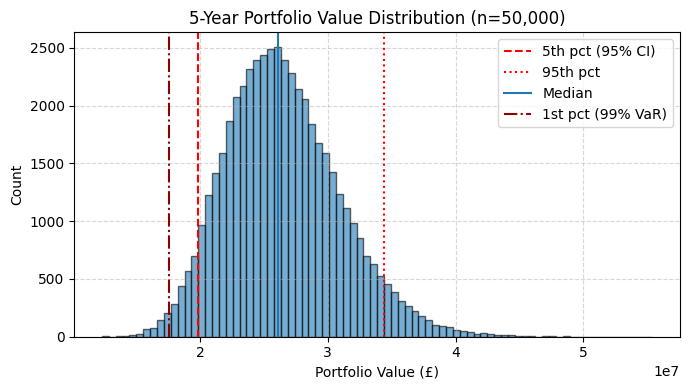

In [591]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─── CONFIG ─────────────────────────────────────────
np.random.seed(42)
n_sims      = 50_000
horizon_yrs = 5
S0          = 20_000_000
tickers     = log_returns.columns
w           = portfolio["Weight"].reindex(tickers).fillna(0.0).values

# ─── UPDATED 5-YEAR EXPECTED RETURNS ───────────────
mu_dict = {
    'JGSA':           0.036863198,
    'SGLN':           0.0454,
    'WMVG LN':        0.063439228,
    'MVEU LN Equity': 0.069757684,
    'TECW LN':        0.063439228,
    'ARTGEIG LN':     0.071387404
}
μ_ann = pd.Series(mu_dict).reindex(tickers).fillna(0.0).values

# ─── ANNUAL COVARIANCE ──────────────────────────────
cov_daily = log_returns.cov().values
Σ_ann     = cov_daily * 252

# ─── PORTFOLIO DRIFT & VOL ─────────────────────────
μ_port    = w @ μ_ann
σ_port    = np.sqrt(w @ Σ_ann @ w)

# ─── SINGLE-STEP 5-YEAR GBM SIMULATION ─────────────
# log S_T = log S0 + (μ_port - ½σ^2)*T + σ*√T*Z
Z         = np.random.randn(n_sims)
drift     = (μ_port - 0.5*σ_port**2) * horizon_yrs
vol       = σ_port * np.sqrt(horizon_yrs) * Z
log_ST    = np.log(S0) + drift + vol
ST        = np.exp(log_ST)

# ─── PERCENTILES & VaR ─────────────────────────────
median   = np.percentile(ST, 50)
lo95     = np.percentile(ST, 5)
hi95     = np.percentile(ST, 95)
VaR99    = np.percentile(ST, 1)

print(f"5-year median    : £{median:,.0f}")
print(f"5-year 95% CI    : £{lo95:,.0f} – £{hi95:,.0f}")
print(f"5-year 99% VaR   : £{VaR99:,.0f}")

# ─── PLOT HISTOGRAM ────────────────────────────────
plt.figure(figsize=(7,4))
plt.hist(ST, bins=80, alpha=0.6, edgecolor='k')
plt.axvline(lo95, color='red', linestyle='--', label='5th pct (95% CI)')
plt.axvline(hi95, color='red', linestyle=':', label='95th pct')
plt.axvline(median, color='C0', linestyle='-', label='Median')
plt.axvline(VaR99, color='darkred', linestyle='-.', label='1st pct (99% VaR)')
plt.title(f"5-Year Portfolio Value Distribution (n={n_sims:,})")
plt.xlabel("Portfolio Value (£)")
plt.ylabel("Count")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

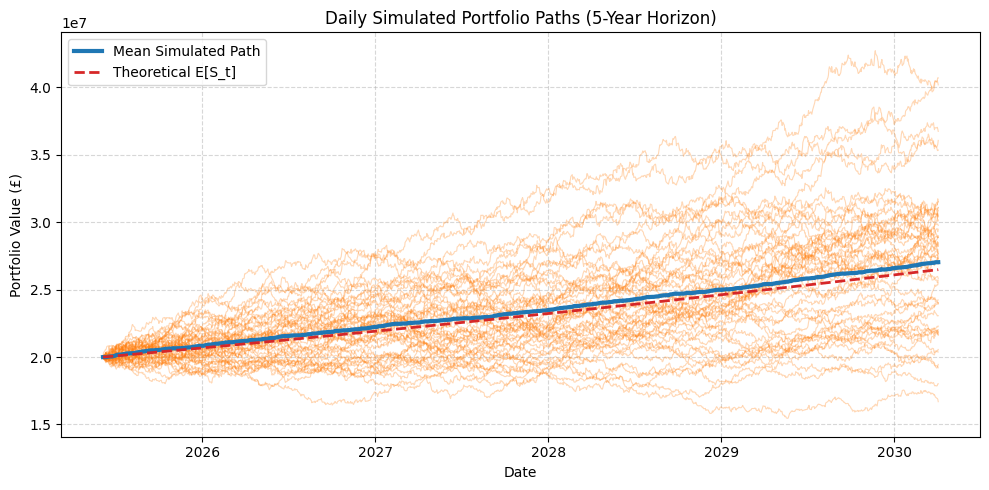

In [592]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

# ─── 0) CONFIGURATION ───────────────────────────────
np.random.seed(123)
n_sims      = 200     # number of sample paths to draw for the plot
years       = 5       # forecast horizon in years
trading_days= 252     # trading days per year
horizon     = years * trading_days
S0          = 20_000_000  # starting portfolio value

# Portfolio weights (must sum to 1)
tickers = log_returns.columns
w = portfolio["Weight"].reindex(tickers).fillna(0.0).values

# Annual expected returns (Blackstone 5-year forecasts)
mu_dict = {
    'JGSA':           0.036863198,
    'SGLN':           0.0454,
    'WMVG LN':        0.063439228,
    'MVEU LN Equity': 0.069757684,
    'TECW LN':        0.063439228,
    'ARTGEIG LN':     0.071387404
}
mu_ann = pd.Series(mu_dict).reindex(tickers).fillna(0.0).values

# Historical daily covariance of log-returns
cov_daily = log_returns.cov().values

# Portfolio daily drift & vol
mu_port_daily    = (w @ mu_ann) / trading_days
sigma_port_daily = np.sqrt(w @ cov_daily @ w)

# ─── 1) SIMULATE DAILY GBM PATHS ────────────────────
# log-return each day: drift -½σ² + σ·Z
drift_term = mu_port_daily - 0.5 * sigma_port_daily**2
Z          = np.random.randn(n_sims, horizon)
daily_logr = drift_term + sigma_port_daily * Z

# cumulative log-return
cum_logr   = np.cumsum(daily_logr, axis=1)

# convert to price paths (start at S0)
price_paths = S0 * np.exp(cum_logr)

# prepend day-0 = S0
price_paths = np.hstack([
    np.full((n_sims, 1), S0),
    price_paths
])

# build future date index
last_date   = log_returns.index[-1]
future_dates= pd.bdate_range(
    start= last_date + BDay(1),
    periods= horizon + 1,
    freq='B'
)

# ─── 2) PLOT A HANDFUL OF PATHS ─────────────────────
plt.figure(figsize=(10,5))
for i in range(min(n_sims, 50)):   # plot up to 50 sample paths
    plt.plot(
        future_dates,
        price_paths[i],
        color='C1',
        alpha=0.3,
        linewidth=0.8
    )
# ─── 3) Compute and plot the average / expected path ────────────────────

# (a) Empirical mean of the simulations
mean_path = price_paths.mean(axis=0)    # shape = (horizon+1,)

# (b) Theoretical expected GBM path
#    E[log S_t] drift term = mu_port_daily * t, so E[S_t] = S0*exp(mu_port_daily * t)
t = np.arange(horizon+1)               # 0,1,2,...,horizon
expected_path = S0 * np.exp(mu_port_daily * t)

# Now plot them on top, with bold styling
plt.plot(
    future_dates, mean_path,
    color='C0', lw=3, label='Mean Simulated Path'
)
plt.plot(
    future_dates, expected_path,
    color='C3', lw=2, linestyle='--', label='Theoretical E[S_t]'
)

plt.legend()



plt.title("Daily Simulated Portfolio Paths (5-Year Horizon)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (£)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [593]:
import numpy as np
import pandas as pd

# Assuming you already have `price_paths` from your daily‐GBM sim:
#   shape = (n_sims, horizon_days+1), with price_paths[:, -1] the 5y value.

final_vals = price_paths[:, -1]

# Build summary stats
stats = {
    'Min':              np.min(final_vals),
    '1st Percentile':   np.percentile(final_vals, 1),
    '5th Percentile':   np.percentile(final_vals, 5),
    'Median (50%)':     np.percentile(final_vals, 50),
    '95th Percentile':  np.percentile(final_vals, 95),
    '99th Percentile':  np.percentile(final_vals, 99),
    'Max':              np.max(final_vals),
    'Mean':             np.mean(final_vals),
    'Std Dev':          np.std(final_vals)
}

df = pd.DataFrame.from_dict(stats, orient='index', columns=['Portfolio Value (£)'])
df['Portfolio Value (£)'] = df['Portfolio Value (£)'] \
    .apply(lambda x: f"{x:,.2f}")

print(df)

                Portfolio Value (£)
Min                   16,688,515.81
1st Percentile        19,190,055.30
5th Percentile        20,374,358.27
Median (50%)          26,660,762.41
95th Percentile       36,678,313.61
99th Percentile       41,751,340.71
Max                   43,563,726.94
Mean                  27,036,827.40
Std Dev                4,925,048.95
